<h1><center><u> Code Implementation </u></center></h1>

# Additional Work: Numerical with Categorical Dataset  
---
---
### Code Implementation Walkthrough

> • **Goal**: Demonstrate missing data imputation with *mixed numerical and categorical* variables using a modular pipeline.
> 
> • **Code Folder**: All core functions are organized in the `src/` directory for clarity and reusability.
> 
> • **Notebook Purpose**: Designed for execution and visualization. This notebook complements the *Additional Work* section of the thesis by supporting exploratory data analysis (EDA) and model evaluation.
>  
> • **Explore**: See `src/utils.py`, `src/evaluation.py`, `src/preprocessing.py`, etc. for all major implementation logic.

---

Once we explore the data and understand the structure of our **numerical + categorical DHS dataset**, we can run the **complete evaluation pipeline**.

**This step will perform:**
- Data loading and preprocessing
- Artificial missingness generation (MCAR and MAR)
- Imputation using multiple methods: Mean, KNN, MICE, AE, DAE, VAE, GAIN
- Performance evaluation (RMSE, MAE, R², Accuracy, F1, Precision, Recall)
- Time and scatter plot generation for visual analysis

**Core pipeline logic is handled by**:
All core logic is handled through the `main.py` script inside the project root and also by calling `src/` modules like:
- `config.py`
- `load_data.py`
- `evaluation.py`
- `run_pipeline.py`
- `visualization.py` etc.

**To run the full pipeline from this notebook:**
```python
# within the notebooks/ folder
%run ../main.py

# Libraries and Setup

Importing necessary libraries for data manipulation, statistical methods, machine learning, deep learning and evaluation.

In [1]:
#importing required libraries

import os
import gc
import sys
import time
import pickle
import joblib
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from icecream import ic
import tensorflow as tf
from scipy import stats
from tensorflow import keras
from scipy.stats import skew
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras import Model
from collections import defaultdict
import tensorflow.keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from tensorflow.keras.losses import mse
from sklearn.impute import SimpleImputer
from scipy.stats import levene, f_oneway
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import mse as keras_mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tensorflow.keras.layers import Lambda, Layer, Input, Dense
from sklearn.linear_model import BayesianRidge, LinearRegression
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, GaussianNoise, Layer
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Sequential, layers, models, optimizers, regularizers
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures, FunctionTransformer
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GaussianNoise, Input, LeakyReLU, Add
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, mean_absolute_error

sys.path.append(os.path.abspath(".."))
from src.utils import *
from src.imputations import *
from src.gain import GAIN_code_v2
from src.load_data import load_data
from src.setup_dirs import setup_directories
from src.config import RESULTS_DIR, GET_FINAL_IMPUTATIONS_DIR
from src.run_pipeline import compute_data, load_or_compute_data_part
from src.masking import apply_masking_for_cat_num, extract_values_using_mask
from src.dhs_modelling_functions_new import final_ds_droping_cols, fold_generator
from src.visualization import missing_ratio_vs_stats, add_jitter_to_mean_accuracy
from src.preprocessing import prepare_data, fold_generator_3_independent_indices, one_hot_encode_for_others, consistent_one_hot_encode
from src.evaluation import evaluate_metrics_part, calculate_metrics, save_metrics_to_excel, missing_ratio_vs_stats, handle_masking_and_evaluation

# initialization
from pandarallel import pandarallel
pandarallel.initialize()

2025-05-22 13:25:08.075860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# calling this function in various parts of the loop to track memory consumption
import psutil
def check_memory():
    print(f"Current memory usage: {psutil.virtual_memory().percent}%")
check_memory()

Current memory usage: 32.1%


In [3]:
# the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /home/myuser/prj/code/final_computation/dataset_num_with_categorical_github/notebooks


In [4]:
# setting up random seeds for reproducibility
tf.random.set_seed(6688)
random.seed(6688)
np.random.seed(6688)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        raise e

# use multiple GPUs
gpus = [0] # may request more, if necessary
gpus = ["GPU:" + str(i) for i in gpus]
# https://keras.io/guides/distributed_training/
print('gpus', gpus)

gpus ['GPU:0']


2025-05-22 13:25:09.316686: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination


# Dataset loading

reference> https://github.com/gheisenberg/FoodSecurity/tree/main/DHS

In [6]:
# to display up to 1000 columns in outputs to ensure wide dataframes 
pd.set_option('display.max_columns', 1000)
# loading the preprocessed household dataset from a manually adjusted pickle file.
# this dataset version (V3) includes cleaned and harmonized features relevant for imputation experiments
df_new = pd.read_pickle('/home/myuser/data/preprocessed_data/DHS_n_more/Manually_adjusted_df_V3_HR.pkl')

In [7]:
df_new.head()

,country code and phase,GEID,DHSID,DHSID + HHID,version_nr,subversion_nr,generated hhnr from case id,generated clnr from case id,cluster number,household number,number of household members,month of interview,year of interview,day of interview,type of place of residence,case identification,source of drinking water,has electricity,has radio,has bicycle,has car/truck,owns sheep,region,type of toilet facility,has refrigerator,number of eligible children for height and weight,translator used,has telephone (land-line),has bank account,total adults measured,language of questionnaire,share toilet with other households,location of source for water,anything done to water to make safe to drink,water usually treated by: boil,water usually treated by: add bleach/chlorine,number of mosquito bed nets,native language of respondent,household selected for domestic violence module,place where household members wash their hands,presence of water at hand washing place,items present: soap or detergent,"items present: ash, mud, sand",items present: none,location of toilet facility,water not available for at least a day last two weeks,has dwelling been sprayed against mosquitoes in last 12 months,dwelling sprayed by: government worker/program,dwelling sprayed by: private company,dwelling sprayed by: ngo,dwelling sprayed by: other,household has separate room used as kitchen,type of cookstove,owns rabbits,person fetching water,has generator,has fan,number of eligible children for height & weight,result of salt test for iodine,water usually treated by: strain through a cloth,cluster altitude in meters,water usually treated by: let it stand and settle,number of eligible women in household,number of eligible men in hh,number of children 5 and under (de jure),number of households sharing toilet,has watch,dvd player,has boat with a motor,sewing machine,has animal-drawn cart,place of residence,has a computer,water usually treated by: other,water usually treated by: solar disinfection,language of interview,type of cooking fuel,food cooked in the house/ separate building/ outdoors,table,has mobile telephone,owns land usable for agriculture,has bed,hectares of agricultural land (1 decimal),number of rooms used for sleeping,chair,has television,owns goats,has motorcycle/scooter,water usually treated by: use water filter,owns horses/ donkeys/ mules,time to get to water source (minutes),owns cows/ bulls,"owns livestock, herds or farm animals",owns chickens/poultry,country code,number of households sharing toilet: applicable
0,AO5,AOGE52FL00000001,AOHR51SV00000001,AOHR51SV0000000100000001,5,1,NaN,NaN,1,1,3.0,12.0,2006.0,2.0,urban,1 1,piped into dwelling,yes,yes,no,yes,NaN,"stable mesoendemic (zaire, luanda, bengo, beng...",flush to piped sewer system,yes,NaN,NaN,NaN,NaN,1.0,NaN,NaN,in own dwelling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lpg,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,yes,NaN,no,NaN,NaN,0.0,NaN,NaN,NaN,AO,applicable
1,AO5,AOGE52FL00000001,AOHR51SV00000001,AOHR51SV0000000100000002,5,1,NaN,NaN,1,2,3.0,12.0,2006.0,2.0,urban,1 2,piped into dwelling,yes,yes,no,no,NaN,"stable mesoendemic (zaire, luanda, bengo, beng...",flush to piped sewer system,yes,NaN,NaN,NaN,NaN,1.0,NaN,NaN,in own dwelling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lpg,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN,yes,NaN,no,NaN,NaN,0.0,NaN,NaN,NaN,AO,applicable
2,AO5,AOGE52FL00000001,AOHR51SV00000001,AOHR51SV0000000100000003,5,1,NaN,NaN,1,3,3.0,12.0,2006.0,2.0,urban,1 3,piped to yard/plot,yes,yes,yes,no,NaN,"stable mesoendemic (zaire, luanda, bengo, beng...",flush to piped sewer system,yes,NaN,NaN,NaN,NaN,0.0,NaN,NaN,in own yard/plot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,N

In [8]:
df_new.columns

Index(['country code and phase', 'GEID', 'DHSID', 'DHSID + HHID', 'version_nr',
       'subversion_nr', 'generated hhnr from case id',
       'generated clnr from case id', 'cluster number', 'household number',
       'number of household members', 'month of interview',
       'year of interview', 'day of interview', 'type of place of residence',
       'case identification', 'source of drinking water', 'has electricity',
       'has radio', 'has bicycle', 'has car/truck', 'owns sheep', 'region',
       'type of toilet facility', 'has refrigerator',
       'number of eligible children for height and weight', 'translator used',
       'has telephone (land-line)', 'has bank account',
       'total adults measured', 'language of questionnaire',
       'share toilet with other households', 'location of source for water',
       'anything done to water to make safe to drink',
       'water usually treated by: boil',
       'water usually treated by: add bleach/chlorine',
       'number of m

In [9]:
numerical_only = df_new.select_dtypes(include=[np.number])
numerical_only.shape

(1853043, 13)

In [10]:
numerical_only = df_new.select_dtypes(exclude=[np.number])
numerical_only.shape

(1853043, 83)

In [11]:
df_new.shape

(1853043, 96)

# Selected Common Features from the Original Household Dataset

Only the common columns are retained from the DHS's original household dataset to maintain consistency and allow comparable downstream processing.

- For having similar columns like original household dataset (numerical+aggregated), prefixes and suffixes are removed from this combined dataset.

- These cleaned features above similar like original household dataset serve as the input space for evaluating the performance of missing data imputation methods on combined  numerical with categorical dataset.

The variables span across several thematic domains:

- **Household Composition & Structure**
  - Number of household members
  - Number of eligible children for height and weight
  - Total adults measured
  - Number of eligible women in household
  - Number of children 5 and under (de jure)
  - Number of rooms used for sleeping
  - Household has separate room used as kitchen

- **Water Access & Treatment**
  - Source of drinking water
  - Location of source for water
  - Time to get to water source (minutes)
  - Anything done to water to make it safe to drink
  - Water treatment methods:
    - Boiling
    - Adding bleach/chlorine
    - Straining through cloth
    - Letting it stand and settle
    - Using a water filter
    - Solar disinfection
    - Other

- **Sanitation Facilities**
  - Type of toilet facility
  - Location of toilet facility
  - Number of households sharing toilet
  - Share toilet with other households
  - Number of households sharing toilet: applicable

- **Asset Ownership**
  - Has electricity, radio, television, refrigerator, mobile phone, land-line phone, bicycle, car/truck, motorcycle/scooter, computer, watch, animal-drawn cart, boat with a motor
  - Owns land usable for agriculture
  - Owns livestock, herds or farm animals (sheep, goats, cows/bulls, horses/donkeys/mules, chickens/poultry)
  - Has bank account

- **Other Socioeconomic Indicators**
  - Type of place of residence (urban/rural)
  - Type of cooking fuel
  - Food cooked in the house/separate building/outdoors
  - Cluster altitude in meters
  - Translator used


### Filtering Columns Based on Main Aggregated Numerical Dataset

This following step ensures consistency between the Original Household Dataset (numerical+aggregated) and the newer combined dataset that includes categorical features. We retain only the selected variables that were previously original numerical dataset. 

> Note: The columns `'URBAN_RURA: R'` and `'FS; IPC: 0-2y'` were present in the main numerical dataset but are **not** part of the categorical dataset. Their absence triggered a KeyError and they have been excluded from the final filtered list.

In [12]:
# list of selected and cleaned numerical + binary categorical features from the old dataset.
# these were confirmed to be relevant and harmonized in earlier preprocessing steps.
# columns such as 'URBAN_RURA: R' and 'FS; IPC: 0-2y' caused KeyError as they do not exist in this df_new
# hence, they were removed from this list before selection.
cleaned_columns_from_old_numerical_dataset = [
    'number of household members',
    'owns sheep',
    'number of eligible children for height and weight',
    'total adults measured',
    'number of mosquito bed nets',
    'cluster altitude in meters',
    'number of eligible women in household',
    'number of children 5 and under (de jure)',
    'number of households sharing toilet',
    'hectares of agricultural land (1 decimal)',
    'number of rooms used for sleeping',
    'owns goats',
    'owns horses/ donkeys/ mules',
    'time to get to water source (minutes)',
    'owns cows/ bulls',
    'owns chickens/poultry',
    'type of place of residence',
    'source of drinking water',
    'has electricity',
    'has radio',
    'has bicycle',
    'has car/truck',
    'type of toilet facility',
    'has refrigerator',
    'translator used',
    'has telephone (land-line)',
    'has bank account',
    'share toilet with other households',
    'location of source for water',
    'anything done to water to make safe to drink',
    'water usually treated by: boil',
    'water usually treated by: add bleach/chlorine',
    'location of toilet facility',
    'household has separate room used as kitchen',
    'water usually treated by: strain through a cloth',
    'water usually treated by: let it stand and settle',
    'has watch',
    'has boat with a motor',
    'has animal-drawn cart',
    'has a computer',
    'water usually treated by: other',
    'water usually treated by: solar disinfection',
    'type of cooking fuel',
    'food cooked in the house/ separate building/ outdoors',
    'has mobile telephone',
    'owns land usable for agriculture',
    'has television',
    'has motorcycle/scooter',
    'water usually treated by: use water filter',
    'owns livestock, herds or farm animals',
    'number of households sharing toilet: applicable'
]

In [13]:
# KeyError: "['URBAN_RURA: R', 'FS; IPC: 0-2y'] not in index"
# safely select only the columns from df_new that match the cleaned list.
# this avoids KeyErrors caused by missing or renamed columns.
df2_filtered = df_new[cleaned_columns_from_old_numerical_dataset]  

# alternatively, drop all columns that are NOT part of the cleaned list (same effect).
# ensures df2_filtered contains only the agreed-upon set of features.
df2_filtered = df_new.drop(columns=[col for col in df_new.columns if col not in cleaned_columns_from_old_numerical_dataset])

# output retained column names to confirm successful filtering.
print("Columns retained from old aggregated numerical Dataset 1, in combined categorical Dataset 2:")
print(df2_filtered.columns)
# df2_filtered.value_counts
# only 51 columns remains as like as main numerical dataset

Columns retained from old aggregated numerical Dataset 1, in combined categorical Dataset 2:
Index(['number of household members', 'type of place of residence',
       'source of drinking water', 'has electricity', 'has radio',
       'has bicycle', 'has car/truck', 'owns sheep', 'type of toilet facility',
       'has refrigerator', 'number of eligible children for height and weight',
       'translator used', 'has telephone (land-line)', 'has bank account',
       'total adults measured', 'share toilet with other households',
       'location of source for water',
       'anything done to water to make safe to drink',
       'water usually treated by: boil',
       'water usually treated by: add bleach/chlorine',
       'number of mosquito bed nets', 'location of toilet facility',
       'household has separate room used as kitchen',
       'water usually treated by: strain through a cloth',
       'cluster altitude in meters',
       'water usually treated by: let it stand and settle

In [14]:
df_new.shape

(1853043, 96)

# Data Cleaning Based on Missingness Threshold

To ensure high data quality for imputation and modeling, we apply a missingness threshold of 40%. The logic below performs the following:

- Drops columns with more than 40% missing values unless they are essential and listed in `columns_to_keep`.
- Drops rows with more than 40% missing values across remaining columns.
- Retains all key variables similar to the main numerical dataset for consistency across experiments.

In [15]:
# setting the missingness threshold: 40%
# means we tolerate up to 40% missing data in rows or columns before removing them.
# setting threshold
threshold = 0.40  

# defining the essential columns to retain (even if missingness exceeds the threshold).
# these are consistent with the main numerical dataset and are considered important for analysis.
# list of columns to keep as like as main numerical dataset
columns_to_keep = [
    'number of household members', 'owns sheep', 'number of eligible children for height and weight',
    'total adults measured', 'number of mosquito bed nets', 'cluster altitude in meters',
    'number of eligible women in household', 'number of children 5 and under (de jure)',
    'number of households sharing toilet', 'hectares of agricultural land (1 decimal)',
    'number of rooms used for sleeping', 'owns goats', 'owns horses/ donkeys/ mules',
    'time to get to water source (minutes)', 'owns cows/ bulls', 'owns chickens/poultry',
    'type of place of residence', 'source of drinking water', 'has electricity', 'has radio',
    'has bicycle', 'has car/truck', 'type of toilet facility', 'has refrigerator', 'translator used',
    'has telephone (land-line)', 'has bank account', 'share toilet with other households',
    'location of source for water', 'anything done to water to make safe to drink',
    'water usually treated by: boil', 'water usually treated by: add bleach/chlorine',
    'location of toilet facility', 'household has separate room used as kitchen',
    'water usually treated by: strain through a cloth', 'water usually treated by: let it stand and settle',
    'has watch', 'has boat with a motor', 'has animal-drawn cart', 'has a computer',
    'water usually treated by: other', 'water usually treated by: solar disinfection',
    'type of cooking fuel', 'food cooked in the house/ separate building/ outdoors',
    'has mobile telephone', 'owns land usable for agriculture', 'has television',
    'has motorcycle/scooter', 'water usually treated by: use water filter',
    'owns livestock, herds or farm animals', 'number of households sharing toilet: applicable'
]

# the percentage of missing values per column.
missing_percentage = df_new.isnull().mean()

# columns with more than 40% missing values AND not part of the columns_to_keep list
# these columns will be dropped from the dataset
columns_to_drop = [col for col in df_new.columns if (missing_percentage[col] > threshold) and (col not in columns_to_keep)]

# dropping the selected columns from the dataset
df_cleaned = df_new.drop(columns=columns_to_drop)

# missing value percentage for each row (axis=1)
row_missing_percentage = df_cleaned.isnull().mean(axis=1)

# identifying rows where more than 40% of values are missing
rows_to_drop = row_missing_percentage[row_missing_percentage > threshold].index

# dropping those rows from the dataset.
df_cleaned = df_cleaned.drop(index=rows_to_drop)

# output dropped columns and number of dropped rows.
print("Dropped columns with > 40% missing values:")
print(columns_to_drop)
print(f"Dropped {len(rows_to_drop)} rows with > 40% missing values.")

Dropped columns with > 40% missing values:
['generated hhnr from case id', 'generated clnr from case id', 'language of questionnaire', 'native language of respondent', 'household selected for domestic violence module', 'place where household members wash their hands', 'presence of water at hand washing place', 'items present: soap or detergent', 'items present: ash, mud, sand', 'items present: none', 'water not available for at least a day last two weeks', 'has dwelling been sprayed against mosquitoes in last 12 months', 'dwelling sprayed by: government worker/program', 'dwelling sprayed by: private company', 'dwelling sprayed by: ngo', 'dwelling sprayed by: other', 'type of cookstove', 'owns rabbits', 'person fetching water', 'has generator', 'has fan', 'number of eligible children for height & weight', 'result of salt test for iodine', 'number of eligible men in hh', 'dvd player', 'sewing machine', 'place of residence', 'language of interview', 'table', 'has bed', 'chair']
Dropped 48

In [16]:
df_cleaned.shape

(1363097, 65)

In [17]:
df_cleaned.head()

,country code and phase,GEID,DHSID,DHSID + HHID,version_nr,subversion_nr,cluster number,household number,number of household members,month of interview,year of interview,day of interview,type of place of residence,case identification,source of drinking water,has electricity,has radio,has bicycle,has car/truck,owns sheep,region,type of toilet facility,has refrigerator,number of eligible children for height and weight,translator used,has telephone (land-line),has bank account,total adults measured,share toilet with other households,location of source for water,anything done to water to make safe to drink,water usually treated by: boil,water usually treated by: add bleach/chlorine,number of mosquito bed nets,location of toilet facility,household has separate room used as kitchen,water usually treated by: strain through a cloth,cluster altitude in meters,water usually treated by: let it stand and settle,number of eligible women in household,number of children 5 and under (de jure),number of households sharing toilet,has watch,has boat with a motor,has animal-drawn cart,has a computer,water usually treated by: other,water usually treated by: solar disinfection,type of cooking fuel,food cooked in the house/ separate building/ outdoors,has mobile telephone,owns land usable for agriculture,hectares of agricultural land (1 decimal),number of rooms used for sleeping,has television,owns goats,has motorcycle/scooter,water usually treated by: use water filter,owns horses/ donkeys/ mules,time to get to water source (minutes),owns cows/ bulls,"owns livestock, herds or farm animals",owns chickens/poultry,country code,number of households sharing toilet: applicable
3004,AO5,AOGE61FL00000013,AOHR62SV00000013,AOHR62SV0000001300000001,5,2,13,1,5.0,3.0,2011.0,14.0,rural,13 1,protected well,no,yes,no,no,NaN,mesoendemica estavel,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,1.0,3.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,no,NaN,NaN,1.0,yes,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,AO,not applicable
3005,AO5,AOGE61FL00000013,AOHR62SV00000013,AOHR62SV0000001300000002,5,2,13,2,6.0,3.0,2011.0,14.0,rural,13 2,protected well,no,yes,no,no,NaN,mesoendemica estavel,no facility/bush/field,yes,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,yes,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,2.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,AO,not applicable
3006,AO5,AOGE61FL00000013,AOHR62SV00000013,AOHR62SV0000001300000003,5,2,13,3,7.0,3.0,2011.0,14.0,rural,13 3,protected well,no,yes,no,no,NaN,mesoendemica estavel,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,yes,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,AO,not applicable
3007,AO5,AOGE61FL00000013,AOHR62SV00000013,AOHR62SV0000001300000004,5,2,13,4,3.0,3.0,2011.0,14.0,rural,13 4,protected well,no,yes,no,no,NaN,mesoendemica estavel,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,0.0,2.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,no,NaN,NaN,1.0,NaN,NaN,NaN,AO,not applicable
3008,AO5,AOGE61FL00000013,AOHR62SV00000013,AOHR62SV0000001300000005,5,2,13,5,4.0,3.0,2011.0,14.0,rural,13 5,protected well,no,yes,no,no,NaN,mesoendemica estavel,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,AO,not applicable


# Dropping Metadata and Non-Informative Columns

The following columns are metadata or technical identifiers (e.g., interview date, household ID, survey version) that do not contribute to the imputation task or predictive modeling. They are dropped from the cleaned dataset to reduce noise and ensure only meaningful categorical variables remain.

In [18]:
meta_and_other_columns_to_drop_for_categoricals_data = [
    'country code and phase',  
    'cluster number', 
    'household number', 
    'month of interview', 
    'day of interview',  
    'case identification',
    'DHSID', 
    'DHSID + HHID', 
    'country code',
    'region',
    'version_nr', 
    'subversion_nr'
]
# dropping the specified columns from the cleaned dataframe
df_cleaned.drop(columns=meta_and_other_columns_to_drop_for_categoricals_data, inplace=True)
print(df_cleaned.head())

                  GEID  number of household members  year of interview  \
3004  AOGE61FL00000013                          5.0             2011.0   
3005  AOGE61FL00000013                          6.0             2011.0   
3006  AOGE61FL00000013                          7.0             2011.0   
3007  AOGE61FL00000013                          3.0             2011.0   
3008  AOGE61FL00000013                          4.0             2011.0   

     type of place of residence source of drinking water has electricity  \
3004                      rural           protected well              no   
3005                      rural           protected well              no   
3006                      rural           protected well              no   
3007                      rural           protected well              no   
3008                      rural           protected well              no   

     has radio has bicycle has car/truck owns sheep type of toilet facility  \
3004       yes     

In [19]:
# df_cleaned.columns.tolist()

### Converting Selected Columns to Numeric Format

Some columns may have been read as object or string types due to inconsistent formatting or embedded non-numeric values. To ensure consistency and compatibility with numerical analyses and imputation techniques, the selected variables below are explicitly converted to numeric types.

- Non-numeric entries will be safely converted to `NaN` using `errors='coerce'`.
- This step preserves missing values while ensuring correct data types for numerical processing.

In [20]:
# converts the column to numeric while keeping NaN values as NaN
# list of columns to convert to numeric
columns_to_convert = [
    'time to get to water source (minutes)',
    'owns chickens/poultry',
    'owns horses/ donkeys/ mules',
    'owns cows/ bulls',
    'owns goats',
    'number of households sharing toilet',
    'number of rooms used for sleeping',
    'hectares of agricultural land (1 decimal)',
    'cluster altitude in meters',
    'number of eligible women in household',
    'number of children 5 and under (de jure)',
    'total adults measured',
    'owns sheep',
    'number of household members',
    'year of interview'
]

# Loop through each column and convert to numeric
# Convert each column to numeric type, coercing any invalid entries to NaN.
for column in columns_to_convert:
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')

# Print the data types of the converted columns to confirm successful transformation.
print(df_cleaned[columns_to_convert].dtypes)

time to get to water source (minutes)        float64
owns chickens/poultry                        float64
owns horses/ donkeys/ mules                  float64
owns cows/ bulls                             float64
owns goats                                   float64
number of households sharing toilet          float64
number of rooms used for sleeping            float64
hectares of agricultural land (1 decimal)    float64
cluster altitude in meters                   float64
number of eligible women in household        float64
number of children 5 and under (de jure)     float64
total adults measured                        float64
owns sheep                                   float64
number of household members                  float64
year of interview                            float64
dtype: object


In [21]:
df_cleaned

,GEID,number of household members,year of interview,type of place of residence,source of drinking water,has electricity,has radio,has bicycle,has car/truck,owns sheep,type of toilet facility,has refrigerator,number of eligible children for height and weight,translator used,has telephone (land-line),has bank account,total adults measured,share toilet with other households,location of source for water,anything done to water to make safe to drink,water usually treated by: boil,water usually treated by: add bleach/chlorine,number of mosquito bed nets,location of toilet facility,household has separate room used as kitchen,water usually treated by: strain through a cloth,cluster altitude in meters,water usually treated by: let it stand and settle,number of eligible women in household,number of children 5 and under (de jure),number of households sharing toilet,has watch,has boat with a motor,has animal-drawn cart,has a computer,water usually treated by: other,water usually treated by: solar disinfection,type of cooking fuel,food cooked in the house/ separate building/ outdoors,has mobile telephone,owns land usable for agriculture,hectares of agricultural land (1 decimal),number of rooms used for sleeping,has television,owns goats,has motorcycle/scooter,water usually treated by: use water filter,owns horses/ donkeys/ mules,time to get to water source (minutes),owns cows/ bulls,"owns livestock, herds or farm animals",owns chickens/poultry,number of households sharing toilet: applicable
3004,AOGE61FL00000013,5.0,2011.0,rural,protected well,no,yes,no,no,NaN,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,1.0,3.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,no,NaN,NaN,1.0,yes,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,not applicable
3005,AOGE61FL00000013,6.0,2011.0,rural,protected well,no,yes,no,no,NaN,no facility/bush/field,yes,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,yes,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,2.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,not applicable
3006,AOGE61FL00000013,7.0,2011.0,rural,protected well,no,yes,no,no,NaN,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,yes,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,not applicable
3007,AOGE61FL00000013,3.0,2011.0,rural,protected well,no,yes,no,no,NaN,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,0.0,2.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,no,NaN,NaN,1.0,NaN,NaN,NaN,not applicable
3008,AOGE61FL00000013,4.0,2011.0,rural,protected well,no,yes,no,no,NaN,no facility/bush/field,no,NaN,NaN,NaN,NaN,NaN,not applicable,in own yard/plot,NaN,NaN,NaN,NaN,elsewhere,NaN,NaN,4.0,NaN,2.0,1.0,10.0,no,no,NaN,NaN,NaN,NaN,charcoal,NaN,yes,NaN,NaN,1.0,no,NaN,yes,NaN,NaN,1.0,NaN,NaN,NaN,not applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853038,ZWGE72FL00000400,5.0,2015.0,rural,protected well,yes,yes,yes,no,0.0,pit latrine with slab,no,1.0,no,no,no,3.0,no,in own yard/plot,yes,no,yes,1.0,in own yard/plot,NaN,no,1413.0,no,2.0,1.0,0.0,no,no,no,no,no,no,wood,in a separate building,yes,no,0.0,2.0,no,7.0,no,no,0.0,0.0,NaN,yes,31.0,applicable
1853039,ZWGE72FL00000400,2.0,2015.0,rural,protected well,no,no,no,no,0.0,no facility/bush/field,no,0.0,no,no,no,0.0,not applicable,in own yard/plot,no,no,no,2.0,elsewhere,NaN,no,1413.0,no,0.0,0.0,10.0,no,no,no,no,no,no,wood,in a separate building,yes,yes,30.0,2.0,no,0.0,no,no,0.0,0.0,NaN,yes,10.0,not applicable
1853040,ZWGE72FL00000400,5.0,2015.0,rural,unprotected well,no,no,no,no,0.0,pit latrine without slab/open pit,no,2.0,no,no,no,1.0,no,elsew

In [22]:
# after dropping irrelevant columns and converting data types, we inspect the dataset to see how many missing (`NaN`) values remain in each column. 
# this summary helps identify which features may still need imputation or further attention
df_cleaned.isnull().sum()

GEID                                                      66624
number of household members                                   0
year of interview                                          7169
type of place of residence                                    0
source of drinking water                                    322
has electricity                                           17946
has radio                                                 28521
has bicycle                                                 874
has car/truck                                              1004
owns sheep                                               208295
type of toilet facility                                     654
has refrigerator                                          13292
number of eligible children for height and weight        318078
translator used                                          558008
has telephone (land-line)                                311488
has bank account                        

# Final Cleanup and Filtering for Final Input

This section performs the final filtering and preparation steps before using the dataset for modeling or imputation tasks:

- Rows with missing `GEID` (a unique household/group identifier) are dropped.
- A custom function `drop_all_nans()` is used to drop all rows that contain any missing values across any column.
- The cleaned dataset is then randomly sampled (9%) for efficient processing in downstream experiments.

In [23]:
# dropping rows where the 'GEID' column has missing values
# 'GEID' is assumed to be a unique group/household identifier essential for analysis.
# dropping rows where the 'GEID' column has missing values
df_cleaned = df_cleaned.dropna(subset=['GEID'])

# verifying that no missing 'GEID' values remain.
print(df_cleaned['GEID'].isna().sum())

# displaying the count of missing values across each column.
# thisgives insight into remaining missingness across the main 37–53 variables.
df_cleaned.isnull().sum()

# at this point, the dataset has 1,363,097 rows and 53 columns.
# defining a function to drop any rows that have missing values in *any* column.

def drop_all_nans(df):
    """
    Drops all rows that contain any NaN values across any column.
    Returns a completely non-missing dataset and prints the resulting shape.
    """
    non_missing_indices = {}
    data_with_missing = df.copy()
    
    # identifying non-missing indices per column
    for col in data_with_missing.columns:
        non_missing_indices[col] = data_with_missing[col].dropna().index
    
    # reconstructing values from non-missing indices, column by column
    values_df = pd.DataFrame()
    for col, indices in non_missing_indices.items():
        values_df[col] = data_with_missing.loc[indices, col].reset_index(drop=True)
    
    # dropping any remaining rows with NaNs
    actual_values_df = values_df.dropna()
    
    # the final shape of the fully cleaned dataset
    rows = actual_values_df.shape
    print(f"Shape after dropping all NaNs: {rows}")
    
    return actual_values_df

# applying the function to obtain the final dataset with no missing values.
input_df = drop_all_nans(df_cleaned)

# double-checking that no NaNs remain in the final dataset.
input_df.isnull().sum()

# randomly sample 9% of the dataset for further experimentation.
# this helps reduce computation time while maintaining representativeness.
input_df = input_df.sample(frac=0.09, random_state=6688)

# displaying the shape of the sampled dataset.
print(input_df.shape)

0
Shape after dropping all NaNs: (594678, 53)
(53521, 53)


In [24]:
input_df.to_csv('/home/myuser/prj/code/final_computation/numerical_with_categorical_dataset_complete_dataset.csv', index=False)

In [25]:
input_df.head(10)

,GEID,number of household members,year of interview,type of place of residence,source of drinking water,has electricity,has radio,has bicycle,has car/truck,owns sheep,type of toilet facility,has refrigerator,number of eligible children for height and weight,translator used,has telephone (land-line),has bank account,total adults measured,share toilet with other households,location of source for water,anything done to water to make safe to drink,water usually treated by: boil,water usually treated by: add bleach/chlorine,number of mosquito bed nets,location of toilet facility,household has separate room used as kitchen,water usually treated by: strain through a cloth,cluster altitude in meters,water usually treated by: let it stand and settle,number of eligible women in household,number of children 5 and under (de jure),number of households sharing toilet,has watch,has boat with a motor,has animal-drawn cart,has a computer,water usually treated by: other,water usually treated by: solar disinfection,type of cooking fuel,food cooked in the house/ separate building/ outdoors,has mobile telephone,owns land usable for agriculture,hectares of agricultural land (1 decimal),number of rooms used for sleeping,has television,owns goats,has motorcycle/scooter,water usually treated by: use water filter,owns horses/ donkeys/ mules,time to get to water source (minutes),owns cows/ bulls,"owns livestock, herds or farm animals",owns chickens/poultry,number of households sharing toilet: applicable
246208,EGGE61FL03990103,4.0,2014.0,rural,sachet water,yes,yes,no,no,0.0,flush to piped sewer system,yes,0.0,no,no,no,0.0,no,in own dwelling,yes,no,no,5.0,in own yard/plot,not applicable,no,308.0,no,1.0,1.0,0.0,no,no,no,no,no,no,no food cooked in house,outdoors,no,no,80.0,3.0,yes,40.0,no,no,0.0,0.0,0.0,yes,0.0,applicable
229200,EGGE5DFL00000971,6.0,2008.0,urban,piped into dwelling,yes,no,no,no,0.0,modern flush toilet,yes,1.0,no,no,yes,1.0,no,in own dwelling,yes,no,no,0.0,in own yard/plot,not applicable,no,424.0,yes,1.0,0.0,0.0,no,no,no,no,no,no,wood,in the house,yes,no,0.0,1.0,yes,0.0,no,no,0.0,0.0,0.0,no,0.0,applicable
88428,BJGE71FL00000535,2.0,2017.0,rural,public tap/standpipe,no,yes,no,no,0.0,no facility/bush/field,no,0.0,no,no,no,2.0,not applicable,elsewhere,yes,yes,no,0.0,in own yard/plot,not applicable,no,1622.0,no,0.0,0.0,0.0,no,no,no,no,no,no,wood,in the house,no,yes,3.0,1.0,no,0.0,no,no,0.0,10.0,0.0,yes,0.0,not applicable
214306,EGGE52FL06640403,8.0,2005.0,urban,piped into dwelling,yes,yes,no,yes,0.0,traditional bucket flush,no,0.0,no,yes,no,1.0,no,in own dwelling,no,no,no,2.0,in own yard/plot,yes,no,1911.0,no,1.0,0.0,0.0,no,no,no,no,no,no,lpg,in the house,yes,no,0.0,2.0,yes,0.0,no,yes,0.0,0.0,0.0,no,0.0,applicable
88831,BJGE71FL00000551,8.0,2018.0,rural,tube well or borehole,no,no,no,no,0.0,no facility/bush/field,no,0.0,no,no,no,0.0,not applicable,elsewhere,no,no,no,1.0,in own yard/plot,not applicable,no,1969.0,no,3.0,2.0,0.0,no,no,no,no,no,no,wood,outdoors,yes,yes,0.0,3.0,no,0.0,yes,no,0.0,10.0,0.0,yes,0.0,not applicable
554532,LSGE71FL00000393,1.0,2014.0,urban,piped to yard/plot,yes,yes,no,no,10.0,no facility/bush/field,no,1.0,no,no,yes,0.0,no,elsewhere,no,no,no,0.0,in own yard/plot,not applicable,no,482.0,no,1.0,0.0,2.0,no,no,no,no,no,no,"firewood, straw",in the house,yes,yes,4.0,2.0,no,0.0,no,no,0.0,4.0,0.0,no,2.0,applicable
44681,BFGE81FL00000030,6.0,2021.0,rural,tube well or borehole,no,yes,yes,no,0.0,ventilated improved pit latrine (vip),no,0.0,no,no,yes,2.0,yes,elsewhere,no,no,no,2.0,elsewhere,not applicable,no,35.0,no,2.0,0.0,2.0,no,no,no,no,no,no,wood,in the house,yes,no,30.0,2.0,no,4.0,yes,no,0.0,30.0,0.0,yes,14.0,applicable
232768,EGGE5DFL00001199,6.0,2008.0,rural,piped into dwelling,yes,yes,no,no,0.0,traditional bucket flush,yes,1.0,no,no,yes,1.0,no,in own dwelling,no,no,no,0.0,in own yard/plot,no,no,21.0,no,1.0,2.0,0.0,yes,no,no,no,no,no,charcoal,in the house,yes,no,10.0,1.0,yes,0.0,no,no,0.0,0.0,0.0,no,0.0,applicable
467070,KEGE8

In [26]:
numerical_only = input_df.select_dtypes(include=[np.number])
numerical_only.shape

(53521, 16)

In [27]:
numerical_only = input_df.select_dtypes(exclude=[np.number])
numerical_only.shape

(53521, 37)

# Dataset contains 'Categorical Imbalance'
### Analysis

This function detects and summarizes imbalance in categorical variables by computing the percentage representation of the most frequent class in each column.

Key Features:
- Automatically detects categorical columns based on data types.
- Displays the top `N` most imbalanced categorical features (highest percentage of top class).
- Helps identify dominant class distributions that may bias learning or require balancing.

In [28]:
def analyze_categorical_imbalance(df, top_n=30):
    """
    Analyze imbalance in the categorical part of a combined dataset.

    Args:
        df: Combined DataFrame with categorical and numerical columns
        top_n: Number of top most imbalanced categorical columns to display

    Returns:
        A summary DataFrame of imbalance metrics per categorical column
    """
    
    # automatically detect categorical columns (dtype: object or category)
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if not categorical_columns:
        print("No categorical columns found in the dataset.")
        return

    imbalance_summary = []

    # analyzing imbalance for each categorical column
    for col in categorical_columns:
        counts = df[col].value_counts(dropna=False)  # include NaNs
        total = counts.sum()
        top_class = counts.idxmax()  # most frequent class
        top_class_pct = (counts.max() / total) * 100

        imbalance_summary.append({
            "Column": col,
            "Top Class": top_class,
            "Top Class Count": counts.max(),
            "Total Count": total,
            "Top Class %": round(top_class_pct, 2)
        })

    # converting results to DataFrame and sort by top class dominance
    summary_df = pd.DataFrame(imbalance_summary)
    summary_df = summary_df.sort_values(by="Top Class %", ascending=False)

    print("\n Imbalance Summary for Categorical Columns:")
    display(summary_df.head(top_n))  # using display() for Jupyter; use print(summary_df.head(top_n)) in scripts

    return summary_df

# running imbalance analysis on the final input DataFrame
summary_df = analyze_categorical_imbalance(input_df)


 Imbalance Summary for Categorical Columns:


,Column,Top Class,Top Class Count,Total Count,Top Class %
27,water usually treated by: solar disinfection,no,53495,53521,99.95
26,water usually treated by: other,no,53418,53521,99.81
23,has boat with a motor,no,53328,53521,99.64
34,water usually treated by: use water filter,no,52707,53521,98.48
21,water usually treated by: let it stand and settle,no,52671,53521,98.41
20,water usually treated by: strain through a cloth,no,52169,53521,97.47
10,has telephone (land-line),no,52018,53521,97.19
25,has a computer,no,50914,53521,95.13
6,has car/truck,no,50841,53521,94.99
24,has animal-drawn cart,no,49682,53521,92.83


## +
Comments:

### Class Imbalance in Categorical Columns from combined DHS dataset and Its real Impact
---
---

An imbalance analysis was conducted across all categorical columns in the combined dataset. The results show **severe class imbalance**, where some classes (e.g., "no", "applicable", "rural") dominate more than **90–99%** of the records.

### Why It Matters:

Such extreme imbalance negatively impacts **classification-based metrics** such as:

- **Precision**
- **Recall**
- **F1-Score**

Even when a model performs well, these metrics may appear **low or misleading** for underrepresented classes because:

- The classifier learns to **default to the majority class**.
- **Minority class instances** are too sparse to influence the model.
- Metrics like **F1-Score** become biased due to limited positive cases.

> In the real world, especially in **household survey datasets**, this level of imbalance is common and expected. Features like "Has car/truck" or "Water treated by: solar disinfection" are naturally skewed.

### Supporting Literature:
- He, H., & Garcia, E. A. (2009). *Learning from imbalanced data.* ACM Computing Surveys (CSUR), 42(1), 1-40.
- Japkowicz, N., & Stephen, S. (2002). *The class imbalance problem: A systematic study.* Intelligent data analysis, 6(5), 429-449.

### How We Handle This:
- All metrics are **interpreted with imbalance in mind**.
- Evaluation is performed across **multiple metrics** (RMSE, R², accuracy, F1, precision) for a balanced overview.
- Class imbalance was not artificially adjusted to reflect **real-world deployment scenarios**.

For a detailed summary, refer to the **Imbalance Summary Table** above.

# Final Pipeline Execution – Additional Work

### To run pipeline for 'numerical with categorical' DHS dataset from notebook

In [29]:
### to enable masking-based evaluation (MAR) or (MCAR)
print("\n========= Starting Evaluation =========")


========= Starting Evaluation =========


### via running main.py

Creating base directory: /home/myuser/prj/code/final_computation/dataset_num_with_categorical_github/results
Loaded dataset with shape: (53521, 53)
The Initial Missingness: 0.0
Using real data: Applying fold_generator_3_independent_indices
Processing fold 1 with masking=False
Loading precomputed train, val, and test sets for fold 1
Processing missing ratio 0.1
All necessary files exist for fold 1 and missing ratio 0.1. Skipping imputation.
Processing missing ratio 0.2
All necessary files exist for fold 1 and missing ratio 0.2. Skipping imputation.
Processing missing ratio 0.3
All necessary files exist for fold 1 and missing ratio 0.3. Skipping imputation.
Processing missing ratio 0.4
All necessary files exist for fold 1 and missing ratio 0.4. Skipping imputation.
Processing missing ratio 0.5
All necessary files exist for fold 1 and missing ratio 0.5. Skipping imputation.
Processing missing ratio 0.6
All necessary files exist for fold 1 and missing ratio 0.6. Skipping imputation.
Proces

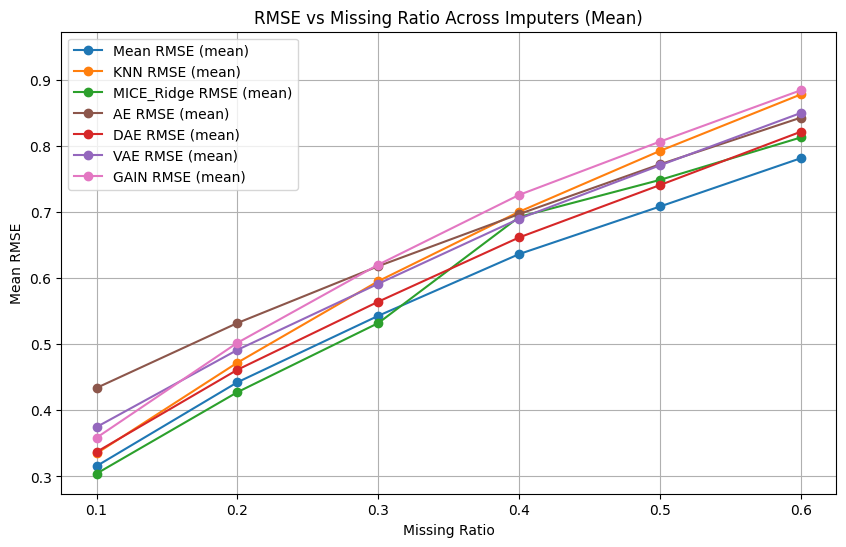

✅ RMSE vs Missing Ratio plot saved to /home/myuser/prj/code/final_computation/dataset_num_with_categorical_github/results/without_masking_rmse_vs_missing_ratio.png


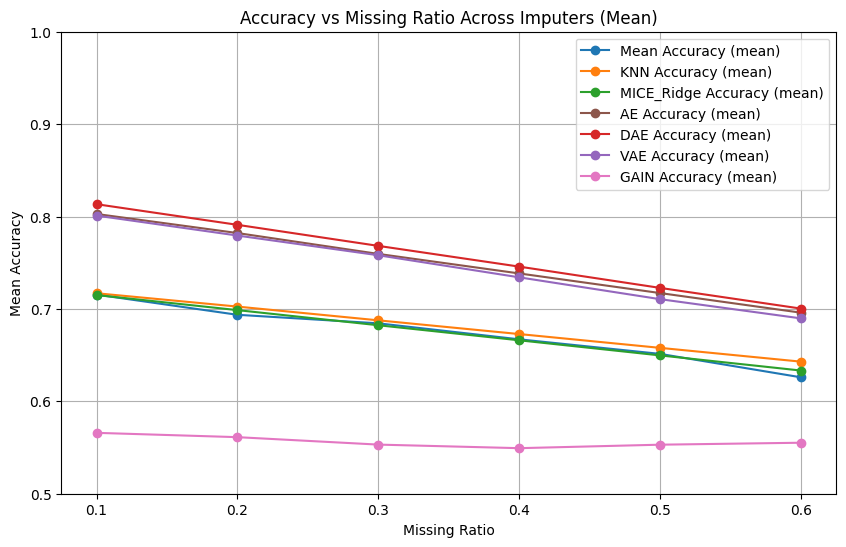

Accuracy vs Missing Ratio plot saved to /home/myuser/prj/code/final_computation/dataset_num_with_categorical_github/results/without_masking_accuracy_vs_missing_ratio.png

All evaluations completed for Numerical with Categorical dataset. Metrics saved.


In [30]:
%run ../main.py

In [31]:
print("\n========= Finished Evaluation =========")


========= Finished Evaluation =========


## Function Reference and Explanation

---
The following codes related to my thesis project's 'Additional Work' section is hidden for clarity. You can find all of these 'important' functions in this folder `src/` → 

### Cross-Validation Fold Generator with Independent Train, Validation, and Test Splits

This function `fold_generator_3_independent_indices()` is designed to generate **three-way splits** (train, validation, and test) for cross-validation, depending on a specified grouping strategy.

It supports the following `split_type` options:
- `'survey'`: Splits based on unique **GEID** values (e.g., survey identifiers).
- `'year'`: Splits based on **rounded year of interview**, averaged per GEID.
- `'unconditional'`: Ignores grouping and applies standard K-Fold split on the full dataset.

Key Features:
- Uses **K-Fold cross-validation** for outer loop splitting.
- Each outer fold produces independent train, validation, and test sets.
- Inner training and validation splits are derived using `train_test_split`.
- Automatically adjusts `n_splits` if the number of unique groups is insufficient.

**Parameters:**
- `data` (`pd.DataFrame`): The full dataset.
- `split_type` (`str`): Splitting strategy – `'survey'`, `'year'`, or `'unconditional'`.
- `n_splits` (`int`): Number of cross-validation folds (outer loop).
- `verbose` (`int`): Controls logging output.
- `val_size` (`float`): Proportion of training+validation split to allocate for validation.

**Yields:**
- A tuple of index arrays: `(train_indices, val_indices, test_indices)`


In [32]:
def fold_generator_3_independent_indices(data, split_type, n_splits=2, verbose=1, val_size=0.2):
    """
    Generate indices for train, validation and test sets based on the specified split type.

    Parameters:
    data (DataFrame): The input dataset.
    split_type (str): The type of split - 'country', 'survey', or 'year'.
    n_splits (int): Number of splits/folds for the outer cross-validation.
    verbose (int): Level of verbosity.
    val_size (float): Proportion of the dataset to include in the validation split.
    """
    if split_type == 'survey':
        split_col = 'GEID'
    elif split_type == 'year':
        split_col = 'year of interview'
        # Ensure 'Meta; rounded year' column is created outside this function or create here based on logic provided
        data[split_col] = data.groupby('GEID')['year of interview'].transform(lambda x: round(x.mean()))
    elif split_type == 'unconditional':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_val_idx, test_idx in kf.split(data):
            # Split the train_val indices into training and validation indices
            train_idx, val_idx = train_test_split(train_val_idx, test_size=val_size, random_state=42)
            yield data.index[train_idx], data.index[val_idx], data.index[test_idx]
        return
    else:
        raise ValueError(f'Invalid split_type: {split_type}')

    unique_combinations = data[split_col].drop_duplicates().values

    # Adjust maximum n_splits based on the number of unique combinations
    if len(unique_combinations) < n_splits or n_splits == -1:
        n_splits = len(unique_combinations)
        if verbose:
            print(f'Adjusting n_splits to the length of unique combinations ({n_splits}) for', split_type)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_val_combinations, test_combinations in kf.split(unique_combinations):
        # Split the train_val combinations into training and validation combinations
        train_combinations, val_combinations = train_test_split(train_val_combinations, test_size=val_size, random_state=42)
        
        # Create masks for training, validation, and test sets
        train_mask = data[split_col].isin(unique_combinations[train_combinations])
        val_mask = data[split_col].isin(unique_combinations[val_combinations])
        test_mask = data[split_col].isin(unique_combinations[test_combinations])
        
        # Get the indices for training, validation, and test sets
        train_indices = data[train_mask].index.values
        val_indices = data[val_mask].index.values
        test_indices = data[test_mask].index.values
        
        # Ensure train size is always larger than test
        assert len(train_indices) > len(test_indices), \
            f"Train size {len(train_indices)} should be larger than test size {len(test_indices)}"

        yield train_indices, val_indices, test_indices

### Masking Function: apply_masking_for_cat_num()

This function introduces artificial missingness into a dataset for experimental purposes, supporting two common missing data mechanisms:

- **MCAR (Missing Completely At Random)**: Randomly masks values across all columns.
- **MAR (Missing At Random)**: Masks values only in certain columns, conditioned on socio-economic variables (e.g., electricity, land ownership).

**Parameters:**
- `X_data` (`DataFrame`): The original dataset to modify.
- `masking` (`bool`): 
  - If `True`, applies MAR logic.
  - If `False`, applies MCAR logic.
- `missingness_fraction` (`float`): Fraction of values to be masked (set to `NaN`) per column.

**Returns:**
- A modified version of `X_data` with `NaN` values.
- A boolean mask (`missing_mask`) where `True` marks a missing value.

This is useful for benchmarking imputation methods under controlled missingness patterns.

In [33]:
def apply_masking_for_cat_num(X_data, masking, missingness_fraction=0.3):
    """
    Apply MAR or MCAR missingness to a given DataFrame.

    Parameters:
    - X_data: pd.DataFrame, original dataset.
    - masking: bool, True = MAR, False = MCAR.
    - missingness_fraction: float, fraction of values to mask.

    Returns:
    - Modified DataFrame with NaNs introduced.
    - missing_mask: Boolean array marking masked positions.
    """
    import numpy as np

    X_data = X_data.copy()  # Prevent modifying original data
    missing_mask = np.zeros(X_data.shape, dtype=bool)  # Mask to track missing entries

    # Columns that MAR logic will condition on (only if present)
    condition_columns = [
        'type of place of residence',
        'has electricity',
        'has bank account',
        'owns land usable for agriculture'
    ]
    condition_columns = [col for col in condition_columns if col in X_data.columns]

    if masking:
        print("🔶 Applying MAR masking based on fixed socio-economic conditions...")

        # Apply missingness only to columns not used as MAR conditions
        target_columns = [col for col in X_data.columns if col not in condition_columns]

        # Define MAR condition: mask is applied where any of these conditions hold
        conditions = (
            (X_data.get('type of place of residence') == 'rural') |
            (X_data.get('has electricity') == 0) |
            (X_data.get('has bank account') == 0) |
            (X_data.get('owns land usable for agriculture') == 1)
        )

        eligible_indices = X_data[conditions].index  # Eligible rows for MAR masking

        # Loop over each target column to apply MAR-style missingness
        for col in target_columns:
            if col not in X_data.columns:
                continue

            non_missing = X_data[col].dropna().index
            col_eligible = non_missing.intersection(eligible_indices)
            num_to_mask = int(np.ceil(missingness_fraction * len(col_eligible)))

            if num_to_mask == 0:
                continue

            # Randomly select rows to mask
            sample_indices = np.random.choice(col_eligible, size=num_to_mask, replace=False)
            local_idx = X_data.index.get_indexer(sample_indices)

            # Update missing mask and set values to NaN
            missing_mask[local_idx, X_data.columns.get_loc(col)] = True
            X_data.loc[sample_indices, col] = np.nan

    else:
        print("Applying MCAR masking (completely random)...")

        # Apply random masking independently to each column
        for col in X_data.columns:
            non_missing_indices = X_data[col].dropna().index
            num_to_mask = int(np.ceil(missingness_fraction * len(non_missing_indices)))

            if num_to_mask == 0:
                continue

            random_sample = np.random.choice(non_missing_indices, size=num_to_mask, replace=False)
            local_indices = X_data.index.get_indexer(random_sample)

            # Apply random NaN and update missing mask
            missing_mask[local_indices, X_data.columns.get_loc(col)] = True
            X_data.loc[random_sample, col] = np.nan

    return X_data, missing_mask

# def apply_masking_for_cat_num(X_data, masking, missingness_fraction):
#     """
#     Apply random missingness to the dataset, with MAR logic applied 
#     when 'type of place of residence' is 'rural'.
    
#     Parameters:
#     - X_data: DataFrame containing the data.
#     - masking: Boolean indicating whether to apply masking.
#     - missingness_fraction: Fraction of data to be set as NaN.
    
#     Returns:
#     - X_data: DataFrame with applied missingness.
#     - missing_mask: Boolean array indicating where values are missing.
#     """
    
#     missing_mask = np.zeros(X_data.shape, dtype=bool)
    
#     if masking:
#         # Get the indices where 'type of place of residence' is 'rural'
#         rural_indices = X_data[X_data['type of place of residence'] == 'rural'].index

#         # Iterate through each column (except 'type of place of residence')
#         for col in X_data.columns:
#             if col == 'type of place of residence':
#                 continue  # Skip the target column itself
            
#             non_missing_indices = X_data[col].dropna().index
            
#             # Calculate the intersection of non-missing and rural indices
#             eligible_indices = non_missing_indices.intersection(rural_indices)
            
#             # Calculate number of samples to mask
#             num_to_mask = int(np.ceil(missingness_fraction * len(eligible_indices)))
#             if num_to_mask == 0:
#                 continue
            
#             # Randomly select from eligible indices (i.e., rows where 'rural' and not already NaN)
#             random_sample = np.random.choice(eligible_indices, size=num_to_mask, replace=False)
#             local_indices = X_data.index.get_indexer(random_sample)
            
#             # Mask the selected values
#             missing_mask[local_indices, X_data.columns.get_loc(col)] = True
#             X_data.loc[random_sample, col] = np.nan

#     else:
#         # Apply random masking (MCAR) to all columns
#         for col in X_data.columns:
#             non_missing_indices = X_data[col].dropna().index
#             random_sample = np.random.choice(non_missing_indices, size=int(np.ceil(missingness_fraction * len(non_missing_indices))), replace=False)
#             local_indices = X_data.index.get_indexer(random_sample)
#             missing_mask[local_indices, X_data.columns.get_loc(col)] = True
#             X_data.loc[random_sample, col] = np.nan
            
#     return X_data, missing_mask

### Data Preparation Function: `prepare_data()`

This function prepares input data for modeling by applying scaling to numerical columns while preserving the original values in categorical columns. It ensures consistency across the training, validation, and test sets.

**Key Features:**
- Automatically identifies numerical and categorical columns.
- Scales only the numerical features using `StandardScaler` (zero mean, unit variance).
- Maintains column ordering to ensure alignment between datasets.

**Parameters:**
- `X_train`, `X_val`, `X_test` (`DataFrame`): Partitioned data subsets.
- `config` (`dict`): Contains pipeline settings, including `scale_numerical_data`.

**Returns:**
- Scaled versions of `X_train`, `X_val`, and `X_test` with both numerical and categorical columns.

In [34]:
def prepare_data(X_train, X_val, X_test, config):
    """
    Prepares the data by scaling numerical columns while leaving categorical columns unchanged.

    Parameters:
    - X_train: Training data (DataFrame).
    - X_val: Validation data (DataFrame).
    - X_test: Test data (DataFrame).
    - config: Dictionary containing configuration options.

    Returns:
    - X_train_scaled: Scaled training data (DataFrame).
    - X_val_scaled: Scaled validation data (DataFrame).
    - X_test_scaled: Scaled test data (DataFrame).
    """
    
    # Identify numerical and categorical columns
    numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    # Initialize copies to preserve structure
    X_train_scaled, X_val_scaled, X_test_scaled = X_train.copy(), X_val.copy(), X_test.copy()

    # Apply scaling to numerical columns if enabled in config
    if config['scale_numerical_data']:
        scaler = StandardScaler()

        # Scale numerical columns while keeping the index
        X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
        X_val_scaled[numerical_columns] = scaler.transform(X_val[numerical_columns])
        X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # Ensure numerical columns come first, followed by categorical columns
    ordered_columns = numerical_columns + categorical_columns
    X_train_scaled = X_train_scaled[ordered_columns]
    X_val_scaled = X_val_scaled[ordered_columns]
    X_test_scaled = X_test_scaled[ordered_columns]

    return X_train_scaled, X_val_scaled, X_test_scaled

### GAIN-Based Imputation Code (Adapted from Open Implementation)
adaptation from: https://github.com/DeltaFloflo/imputation_comparison/blob/main/build/class_gain.py

The full implementation of a modified **GAIN (Generative Adversarial Imputation Network)** is integrated for handling missing data in tabular 'numerical with categorical' DHS dataset. The approach is based on the adversarial framework, where:

- The **Generator (G)** fills in missing values.
- The **Discriminator (D)** tries to distinguish observed from imputed values using a hint matrix.

#### Main Components:

- `normalization()` / `renormalization()`: Min-max normalization utilities.
- `reset_weights()`: Re-initializes model weights for reproducibility.
- `maskDistribution()` and `drawMasks()`: Utilities to mimic real-world missingness patterns.
- `drawHintMatrix()`: Constructs hint matrix for training.
- `make_GAINgen()` / `make_GAINdisc()`: Neural architectures for Generator and Discriminator.
- `GAIN_code_v2`: Class implementing training, loss calculation and imputation pipeline.
  
#### Normalization Utilities
GAIN expects normalized numerical input. We use Min-Max normalization here.

#### Resetting Model Weights
This function ensures the Generator and Discriminator can be retrained cleanly from scratch.

#### Mask and Hint Matrix Utilities
Helps generate masks that simulate missingness and hint matrices that reveal partial observations to the discriminator.

#### GAIN Network Architectures
Generator and Discriminator models with dropout and batch normalization.

#### GAIN Training Logic (GAIN_code_v2 Class)
Combines the generator and discriminator into the GAIN framework, with customized loss functions for adversarial training and reconstruction.


This version supports:
- Conditional treatment of categorical columns (`cat_mask`)
- Separate reconstruction and adversarial loss components
- Tracking of loss curves across epochs

In [35]:
# Based on: https://github.com/DeltaFloflo/imputation_comparison

# -----------------------------------------------------------------------
# GAIN (Generative Adversarial Imputation Networks) - Implementation
# -----------------------------------------------------------------------

# importing required libraries
import numpy as np
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# -----------------------
# Normalization Utilities
# -----------------------

# required TensorFlow Keras components for the GAIN model
# normalizes numerical data between [0, 1] for stable training
def normalization(data, norm_params=None, numeric_mask=None):
    """
    Normalizes numerical columns in the dataset to [0, 1] range.
    """
    N, D = data.shape
    norm_data = data.copy()

    if numeric_mask is None:
        numeric_mask = np.array([np.issubdtype(data[:, d].dtype, np.number) for d in range(D)])

    if norm_params is None:
        # computing min and max for each column
        min_val = np.zeros(D)
        max_val = np.zeros(D)
        for d in range(D):
            if numeric_mask[d]:
                m1 = np.nanmin(data[:, d])
                m2 = np.nanmax(data[:, d])
                min_val[d] = m1
                max_val[d] = m2
                # applying min-max normalization
                norm_data[:, d] = (data[:, d] - m1) / (m2 - m1 + 1e-6)
        norm_params = {"min_val": min_val, "max_val": max_val}
    else:
        # uses previously stored parameters
        min_val = norm_params["min_val"]
        max_val = norm_params["max_val"]
        for d in range(D):
            if numeric_mask[d]:
                m1 = min_val[d]
                m2 = max_val[d]
                norm_data[:, d] = (data[:, d] - m1) / (m2 - m1 + 1e-6)

    return norm_data, norm_params

# reverts min-max normalization
def renormalization(norm_data, norm_params):
    """
    Reverses normalization back to original scale.
    """
    N, D = norm_data.shape
    min_val = norm_params["min_val"]
    max_val = norm_params["max_val"]
    data = norm_data.copy()
    for d in range(D):
        m1 = min_val[d]
        m2 = max_val[d]
        data[:, d] = norm_data[:, d] * (m2 - m1 + 1e-6) + m1
    return data

# ----------------------
# Model Reset Utility
# ----------------------

# reinitializes all model weights (for clean retraining)
def reset_weights(model):
    """
    Reinitialize weights of all layers in a Keras model.
    """
    """Completely reinitialize model parameters"""
    for layer in model.layers:
        if layer.name[:5] == "dense":
            # getting the shape of the kernel (weights) to determine the input and output dimensions
            # Xavier/Glorot uniform initialization
            kernel_shape = layer.kernel.shape  # alternatively, layer.weights[0].shape
            
            nb_in = kernel_shape[0]  # input dimension
            nb_out = kernel_shape[1]  # output dimension
            limit = np.sqrt(6.0 / (nb_in + nb_out))
            
            # reinitialize the kernel (weights) and bias
            r1 = np.random.uniform(-limit, limit, size=kernel_shape)
            r2 = np.zeros(shape=layer.bias.shape)
            
            layer.set_weights([r1, r2])
        
        elif layer.name[:19] == "batch_normalization":
            # getting the shape of the gamma (scaling factor) to initialize batch normalization parameters
            # resetting batch norm parameters
            gamma_shape = layer.gamma.shape  # alternatively, layer.weights[0].shape
            
            r1 = np.ones(shape=gamma_shape)  # gamma
            r2 = np.zeros(shape=gamma_shape)  # beta
            r3 = np.zeros(shape=gamma_shape)  # moving mean
            r4 = np.ones(shape=gamma_shape)  # moving variance
            
            layer.set_weights([r1, r2, r3, r4])

# ----------------------------------------
# Mask Distribution and Sampling Functions
# ----------------------------------------

# extracts distribution of missingness masks in dataset
def maskDistribution(dataset):
    """
    Get the unique missingness patterns and their counts from dataset.
    """
    """unique_masks: list of unique NaN masks found in the dataset
    count_masks: corresponding number of occurrences (the probability distrib.)"""
    mask = (1.0 - np.isnan(dataset)).astype("int")
    unique_masks = np.unique(mask, axis=0)
    count_masks = np.zeros(len(unique_masks), dtype="int")
    for i1 in range(mask.shape[0]):
        current_mask = mask[i1]
        i2 = np.where((unique_masks == current_mask).all(axis=1))[0][0]
        count_masks[i2] += 1
    return unique_masks, count_masks

# samples new missingness patterns from the mask distribution
def drawMasks(unique_masks, probs, N):
    """
    Sample N new masks from the known distribution.
    """
    """unique_masks: list of unique masks from which to choose
    probs: vector of probability (should sum up to one)
    N: number of samples to draw
    masks: list of size N containing one mask per row drawn from the desired distribution"""
    multinom = np.random.multinomial(n=1, pvals=probs, size=N)
    indices = np.where(multinom==1)[1]
    masks = unique_masks[indices]
    return masks

# creates the hint matrix that reveals part of the mask to the discriminator
def drawHintMatrix(p, nb_rows, nb_cols):
    """
    Generate hint matrix with given probability.
    """
    """p: probability of ones
    nb_rows: number of desired rows in the hint matrix H
    nb_cols: number of desired columns in the hint matrix H
    H: hint matrix"""
    H = np.random.uniform(0., 1., size=(nb_rows, nb_cols))
    H = 1.0 * (H < p)
    return H

# --------------------------------------------
# GAIN Generator and Discriminator Builders
# --------------------------------------------

# generator network of GAIN
def make_GAINgen(dim):
    """
    Generator network: predicts missing values.
    """
    model = Sequential([
        Dense(512, activation="relu", kernel_regularizer=l2(1e-4), input_shape=(2*dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(512, activation="relu", kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(dim, activation="sigmoid")
    ])
    return model

# discriminator network of GAIN
def make_GAINdisc(dim):
    """
    Discriminator network: distinguishes observed vs. imputed entries.
    """
    model = Sequential([
        Dense(512, activation="relu", input_shape=(2*dim,), kernel_regularizer=l2(1e-4)), # specifically manually configured for categorical with numerical dataset
        Dropout(0.3),
        Dense(512, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(dim, activation="sigmoid")
    ])
    return model

# -------------------------------------------
# GAIN Code Version 2 (Training + Imputation)
# -------------------------------------------

# the GAIN_code_v2 class
class GAIN_code_v2:
    def __init__(self, dim, cat_mask=None):
        self.dim = dim
        self.G = make_GAINgen(dim) # generator
        self.D = make_GAINdisc(dim) # discriminator
        self.Goptim = tf.keras.optimizers.Adam(learning_rate=0.0005)
        self.Doptim = tf.keras.optimizers.Adam(learning_rate=0.0005)
        self.alpha = 100 # reconstruction vs adversarial loss weight # Weight for reconstruction loss
        self.hint_rate = 0.9 # % of known features revealed to discriminator
        self.trained = False
        self.nb_epochs = 0
        self.Gloss1 = [] # adversarial loss
        self.Gloss2 = [] # reconstruction loss
        self.Dloss = []
        self.cat_mask = tf.convert_to_tensor(cat_mask, dtype=tf.float32) if cat_mask is not None else None

    # discriminator loss: Binary cross-entropy with hint masking
    @staticmethod
    def compute_D_loss(D_output, M, H):
        """
        Discriminator loss (binary cross-entropy)
        """
        L1 = M * tf.math.log(D_output + 1e-6)
        L2 = (1.0 - M) * tf.math.log(1.0 - D_output + 1e-6)
        L = - (L1 + L2) * tf.cast((H == 0.5), dtype=tf.float32)
        nb_cells = tf.math.reduce_sum(tf.cast((H == 0.5), dtype=tf.float32))
        return tf.math.reduce_sum(L) / nb_cells if nb_cells > 0 else 0.0
        
    # generator loss: fool discriminator + minimize reconstruction error
    def compute_G_loss(self, G_output, D_output, X, M, H):
        """
        Generator loss: adversarial + reconstruction components
        """
        Ltemp = - ((1.0 - M) * tf.math.log(D_output + 1e-6))
        L = Ltemp * tf.cast((H == 0.5), dtype=tf.float32)
        nb_cells1 = tf.math.reduce_sum(tf.cast((H == 0.5), dtype=tf.float32))
        loss1 = tf.math.reduce_sum(L) / nb_cells1 if nb_cells1 > 0 else 0.0

        squared_err = ((X - G_output) ** 2) * M
        if self.cat_mask is not None:
            weighted_err = squared_err * (2.0 * self.cat_mask + 1.0 * (1.0 - self.cat_mask))
        else:
            weighted_err = squared_err

        nb_cells2 = tf.math.reduce_sum(M)
        loss2 = tf.math.reduce_sum(weighted_err) / nb_cells2 if nb_cells2 > 0 else 0.0
        return loss1, loss2
        
    # reset model for fresh training
    def reinitialize(self):
        reset_weights(self.G)
        reset_weights(self.D)
        self.trained = False
        self.nb_epochs = 0
        self.Gloss1 = []
        self.Gloss2 = []
        self.Dloss = []

    # single training step (compiled for speed with @tf.function)
    @tf.function
    def train_step(self, batch_data):
        """
        One training iteration for both generator and discriminator.
        """
        cur_batch_size = batch_data.shape[0]
        noise = tf.random.normal([cur_batch_size, self.dim], dtype=tf.float32)
        batch_data = tf.cast(batch_data, dtype=tf.float32)
        M = 1.0 - tf.cast(tf.math.is_nan(batch_data), dtype=tf.float32)
        X = tf.where(tf.math.is_nan(batch_data), noise, batch_data)
        G_input = tf.concat((X, M), axis=1)

        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            G_output = self.G(G_input, training=True)
            X_hat = X * M + G_output * (1.0 - M)
            # constructs hint matrix
            Htemp = tf.cast(drawHintMatrix(self.hint_rate, cur_batch_size, self.dim), dtype=tf.float32)
            H = M * Htemp + 0.5 * (1.0 - Htemp)
            D_input = tf.concat((X_hat, H), axis=1)
            D_output = self.D(D_input, training=True)

            D_loss = self.compute_D_loss(D_output, M, H)
            G_loss1, G_loss2 = self.compute_G_loss(G_output, D_output, X, M, H)
            G_loss = G_loss1 + self.alpha * G_loss2

            G_gradients = G_tape.gradient(G_loss, self.G.trainable_variables)
            D_gradients = D_tape.gradient(D_loss, self.D.trainable_variables)

            self.Goptim.apply_gradients(zip(G_gradients, self.G.trainable_variables))
            self.Doptim.apply_gradients(zip(D_gradients, self.D.trainable_variables))

            return G_loss1, G_loss2, D_loss
            
    # full training loop
    def train(self, dataset, batch_size=8192, epochs=20):
        """
        Train GAIN model on the full dataset.
        """
        for epoch in range(epochs):
            G_temp1, G_temp2, D_temp = [], [], []
            for batch_idx in range(0, dataset.shape[0], batch_size):
                batch_data = dataset[batch_idx:batch_idx + batch_size]
                G_loss1, G_loss2, D_loss = self.train_step(batch_data)
                G_temp1.append(G_loss1.numpy())
                G_temp2.append(G_loss2.numpy())
                D_temp.append(D_loss.numpy())
            self.Gloss1.append(np.mean(G_temp1))
            self.Gloss2.append(np.mean(G_temp2))
            self.Dloss.append(np.mean(D_temp))
            
    # impute missing values using the trained generator
    def impute(self, nandata):
        """
        Impute missing entries in the input using trained generator.
        """
        noise = tf.random.normal([nandata.shape[0], self.dim])
        M_impute = 1.0 - np.isnan(nandata)
        X_impute = tf.where((M_impute == 0.0), noise, nandata)
        G_input = tf.concat((X_impute, M_impute), axis=1)
        G_output = self.G(G_input, training=False)
        imputed_data = (X_impute * M_impute + G_output * (1.0 - M_impute)).numpy()
        return imputed_data